/home/dronelab/delaunay_rasterization


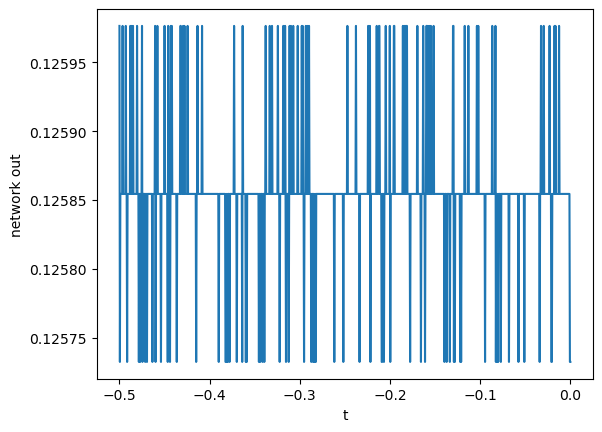

In [243]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import torch
import numpy as np
import tinycudann as tcnn
import matplotlib.pyplot as plt
from utils.contraction import contract_mean_std

sigma = 1
device = torch.device('cuda')
L = 16
dim = 4
encoding = tcnn.Encoding(3, dict(
    otype="HashGrid",
    n_levels=L,
    n_features_per_level=dim,
    log2_hashmap_size=14,
    base_resolution=16,
    per_level_scale=2
)).to(device)

network = tcnn.Network(encoding.n_output_dims, 4, dict(
    # otype="CutlassMLP",
    otype="FullyFusedMLP",
    # activation="Softplus",
    # activation="LeakyReLU",
    activation="Squareplus",
    # activation="Sigmoid",
    output_activation="None",
    n_neurons=64,
    n_hidden_layers=2,
))
# net = torch.nn.Sequential(
#     encoding, network
# ).to(device)

d = 2*torch.rand(3, device=device)-1
d = d / torch.linalg.norm(d)
o = torch.zeros((3), device=device)

t = torch.linspace(-0.5, 0, 1000, device=device)
inputs = o.reshape(1, 3) + t.reshape(-1, 1) * d.reshape(1, 3)
inputs, _ = contract_mean_std(inputs, torch.ones_like(inputs[:, 0]))

n = torch.arange(L, device=device)
scaling = torch.erf(1 / (8*n*sigma).sqrt())
# scaling[1:] = 0
output = encoding(inputs)

output = output.reshape(-1, dim, L)
output = output * scaling.reshape(1, 1, -1)
output = network(output.reshape(-1, dim*L))

# output = output.reshape(-1, dim, L)
# output = output * scaling.reshape(1, 1, -1)
# output = output.sum(dim=2)

# output = output.reshape(-1, L, dim)
# output = output * scaling.reshape(1, -1, 1)
# output = output.sum(dim=1)


y = output[:, 1].detach().cpu()
x = t.cpu()
plt.plot(x, y)
# plt.xlabel = "t"
# plt.ylabel = "network out"
plt.xlabel("t")  # Use function call, not assignment
plt.ylabel("network out")  # Use function call, not assignment
plt.show()

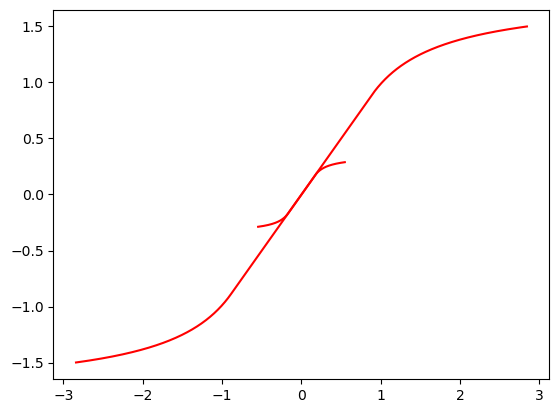

In [237]:
t = torch.linspace(-3.2, 3.2, 1000, device=device)
i1 = o.reshape(1, 3) + t.reshape(-1, 1) * d.reshape(1, 3)
i2, _ = contract_mean_std(i1, torch.ones_like(i1[:, 0]))
i1 = i1.cpu()
i2 = i2.cpu()
# plt.plot(i1[:, 0], i1[:, 1], c='r')
# plt.plot(i2[:, 0], i2[:, 1], c='g')
plt.plot(i1[:, 0], i2[:, 0], c='r')
plt.plot(i1[:, 1], i2[:, 1], c='r')
# plt.scatter(i2[:, 0], i2[:, 1], c='g')
plt.show()

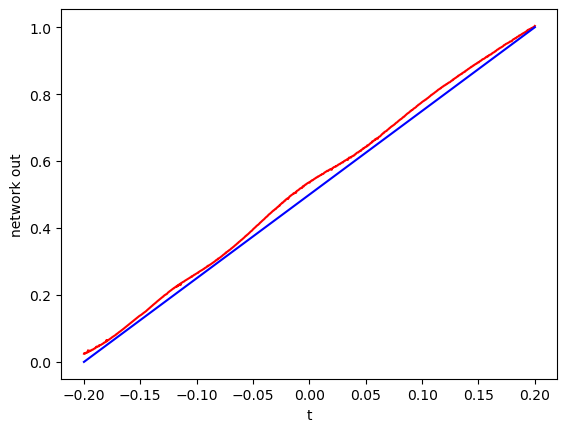

In [244]:
gt = 2 * t + 1

sigma = 10
device = torch.device('cuda')
L = 16
dim = 4
encoding = tcnn.Encoding(3, dict(
    otype="HashGrid",
    n_levels=L,
    n_features_per_level=dim,
    log2_hashmap_size=16,
    base_resolution=16,
    per_level_scale=2
)).to(device)
network = tcnn.Network(encoding.n_output_dims, 4, dict(
    # otype="CutlassMLP",
    otype="FullyFusedMLP",
    # activation="Softplus",
    activation="Squareplus",
    # activation="Sigmoid",
    # activation="ReLU",
    output_activation="None",
    n_neurons=64,
    n_hidden_layers=2,
))
# encoding = torch.nn.Sequential(
#     encoding, network
# ).to(device)
t = torch.linspace(-0.2, 0.2, 1000, device=device)
inputs = o.reshape(1, 3) + t.reshape(-1, 1) * d.reshape(1, 3)
inputs, _ = contract_mean_std(inputs, torch.ones_like(inputs[:, 0]))

optim = torch.optim.Adam(list(encoding.parameters()) + list(network.parameters()), lr=1e-2)
for i in range(50):
    output = encoding(inputs)

    # output = output.reshape(-1, dim, L).permute(0, 2, 1)
    # n = torch.arange(L, device=device)
    # scaling = torch.erf(1 / (8*n*sigma).sqrt())
    # # output = output * scaling.reshape(1, -1, 1)
    # output = output.sum(dim=1)
    output = output.reshape(-1, dim, L)
    output = output * scaling.reshape(1, 1, -1)
    output = network(output.reshape(-1, dim*L))

    output = output[:, 1]

    loss = ((output - gt)**2).mean()
    loss.backward()
    optim.step()
    optim.zero_grad()

y = output.detach().cpu()
x = t.cpu()
plt.plot(x, y, c='r')
plt.plot(x, gt.cpu(), c='b')
# plt.xlabel = "t"
# plt.ylabel = "network out"
plt.xlabel("t")  # Use function call, not assignment
plt.ylabel("network out")  # Use function call, not assignment
plt.show()

In [239]:
help(encoding)

Help on Encoding in module tinycudann.modules object:

class Encoding(Module)
 |  Encoding(n_input_dims, encoding_config, seed=1337, dtype=None)
 |  
 |  Input encoding to a neural network.
 |  
 |  Takes a `torch.float` input tensor of shape `[:, n_input_dims]` and maps
 |  it to a `dtype` tensor of shape `[:, self.n_output_dims]`, where
 |  `self.n_output_dims` depends on `n_input_dims` and the configuration
 |  `encoding_config`.
 |  
 |  Parameters
 |  ----------
 |  n_input_dims : `int`
 |          Determines the shape of input tensors as `[:, n_input_dims]`
 |  encoding_config: `dict`
 |          Configures the encoding. Possible configurations are documented at
 |          https://github.com/NVlabs/tiny-cuda-nn/blob/master/DOCUMENTATION.md
 |  seed: `int`
 |          Seed for pseudorandom parameter initialization
 |  dtype: `torch.dtype`
 |          Precision of the output tensor and internal parameters. A value
 |          of `None` corresponds to the optimally performing preci